# Stellar Classification

![bonk](galaxies.gif "bonk")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## DATA PROCESSING

In [3]:
# Load data from csv file
data = pd.read_csv("star_classification.csv")

data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
# Check data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),


The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar (13).

0. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS X
1. alpha = Right Ascension angle (at J2000 epoch) X
2. delta = Declination angle (at J2000 epoch) X
3. u = Ultraviolet filter in the photometric system
4. g = Green filter in the photometric system
5. r = Red filter in the photometric system
6. i = Near Infrared filter in the photometric system
7. z = Infrared filter in the photometric system
8. run_ID = Run Number used to identify the specific scan X
9. rereun_ID = Rerun Number to specify how the image was processed X
10. cam_col = Camera column to identify the scanline within the run X
11. field_ID = Field number to identify each field X
12. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share theoutput class) X
13. class = object class (galaxy, star or quasar object)
14. redshift = redshift value based on the increase in wavelength
15. plate = plate ID, identifies each plate in SDSS X
16. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken X
17. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation X

As observed before, none of the examples have null values for any feature. However, after analyzing the description of each feature, we decided to discard features which we considered irrelevant to the stellar classification problem. For example, features 0, 8, 9 or 11 are related with ID's used on the process of taking the pictures of the stellar bodies; meanwhile, alpha and delta are related to the angular distance between the point on Earth where the picture was taken, and the celestial body, having no relation to the classification of the latter.
Thus, the relevant features are u, g, r, i, z and redshift (parameters related to the filters of the photometric system).

In [5]:
# Drop irrelevant features
data = data.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID'], axis = 1)

In [6]:
# Class analysis
data["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

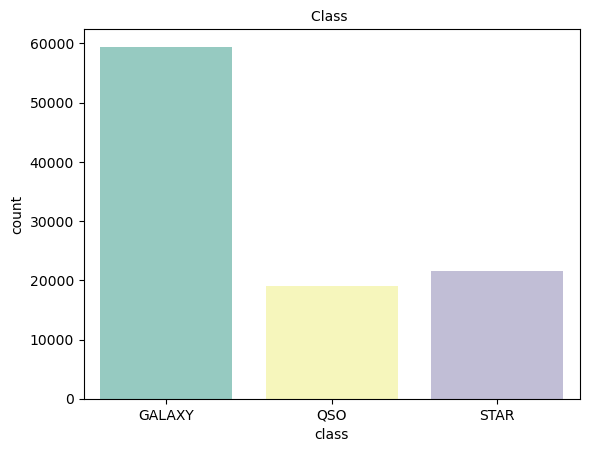

In [7]:
sea.countplot(x=data["class"], palette="Set3")
plt.title("Class ",fontsize=10)
plt.show()

There are around 60000 examples classified as "Galaxy", while the number of examples classified as both of the other categories are around 20000. Thus, we have a class imbalance problem. As such, we will re-sample the data, using an oversampling method on the QSO and Star examples.

However, we must first convert the classes from string to integers (0-2)

In [8]:
# Convert Class from string to int
data["class"] = [0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]

In [9]:
# Before balancing the features remove class label
x = data.drop(['class'], axis = 1)
y = data.loc[:,'class'].values

# Generate examples for QSO and Star class
sm = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
x, y = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 59445, 1: 21594, 2: 18961})
Resampled dataset shape Counter({0: 59445, 2: 59445, 1: 59445})


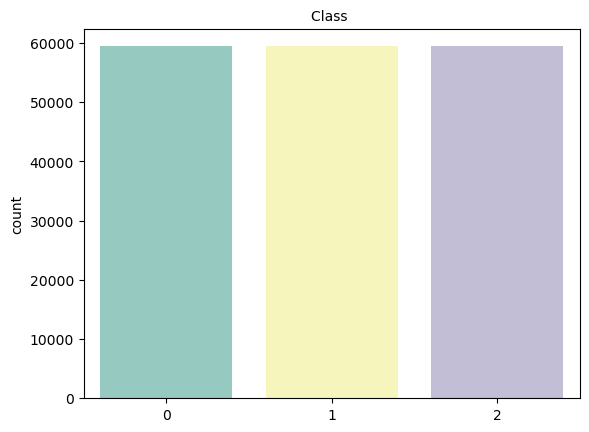

In [10]:
sea.countplot(x=y, palette='Set3')
plt.title("Class ",fontsize=10) 
plt.show()

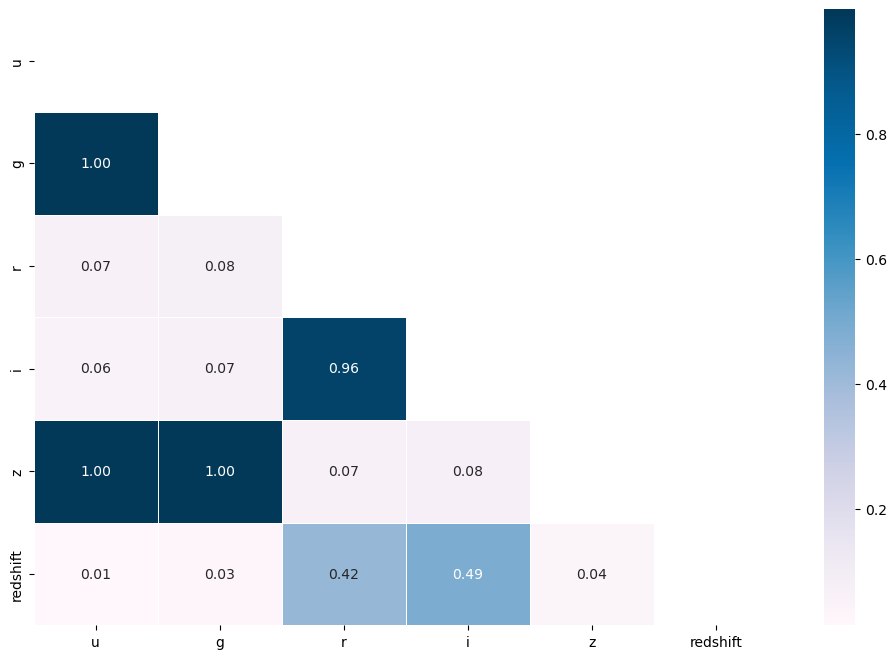

In [11]:
f,ax = plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(x.corr()))
sea.heatmap(x.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax, mask=mask)
plt.show()

After analysing the heatmap we decided that u, g and z have the same impact, which means that they are not needed at the same time, therefore we dropped u and z.

In [12]:
# Drop similar features based on the heatmap
x = x.drop(['u', 'z'], axis = 1)

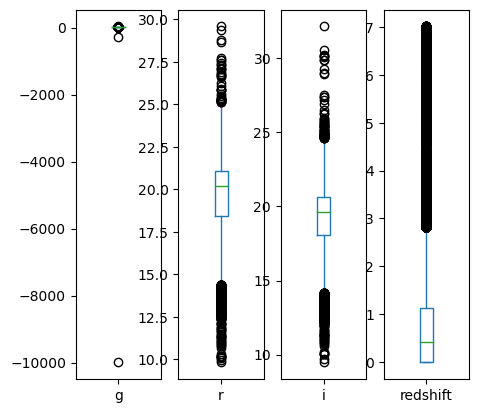

In [13]:
# Box and Whisker Plots
x.plot(kind='box', subplots=True, layout=(1, 5), sharex=False, sharey=False)
plt.show()

In [14]:
x2 = x.copy()
x2['class'] = y

In [15]:
# Scatterplot Matrix
# sea.pairplot(x2, hue='class')

With the previous plots we verified that there are some outliers values in the features, so to balance the data we decided to remove them.

In [16]:
columns = x2.columns.tolist()

print('Shape before filtering: ', x2.shape)

for col in columns:
    if col == 'class':continue
    q1 = x2[col].quantile(0.25)
    q3 = x2[col].quantile(0.75)
    iqr = q3 - q1

    filter = (x2[col] >= q1 - 1.5 * iqr) & (x2[col] <= q3 + 1.5 * iqr)
    x2 = x2.loc[filter]

print('Shape after filtering: ', x2.shape)

Shape before filtering:  (178335, 5)
Shape after filtering:  (172443, 5)


In [17]:
# Scatterplot Matrix
# sea.pairplot(x2, hue='class')

In [18]:
y = x2.loc[:,'class'].values
x2 = x2.drop(['class'], axis = 1)

# Data scaling
scaler = StandardScaler()
scaler.fit(x2)
X_scaled = scaler.transform(x2)

## MODEL TRAINING 

We decided to follow the holdout method. As such, we now need to divide the data set into two new sets, the training and test sets, with a division of 70%-30%.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.30, random_state = 42)

### Step 1: Initial Training of Each ML model

Now, we will train each of the ML models studied in this project once, with the train and tests sets obtained before, using the default hyper-parameter values given by the sklearn package. We will analyze each of their performance matrics and confusion matrixes, before doing the hyper-parameter tuning.

In [20]:
def basic_train_and_test(clf, X_train, X_test, y_train, y_test):

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("Classification Report: ")
    print()
    target_names = ['GALAXY', 'STAR', 'QUASAR']
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("Balanced accuracy score: ")
    print(balanced_accuracy_score(y_test, y_pred))

    print("\nConfusion Matrix: ")
    print()
    matrix = confusion_matrix(y_test, y_pred)
    sea.heatmap(matrix, cmap="PuBu", annot=True, linewidths=0.5, fmt= 'd')
    
    return y_pred

#### Logistic Regression

We will test the Logistic Regression model with no regularizaiton, L1 regularization or L2 regularization. 

The optimization aglorithm used will be the saga algorithm (Stochastic Average Gradient), as that is the one suggested when the features are scaled, and is also usable whether L1 or L2 regularization is applied.

Classification Report: 

              precision    recall  f1-score   support

      GALAXY       0.92      0.93      0.93     17685
        STAR       0.97      1.00      0.99     17723
      QUASAR       0.95      0.92      0.93     16325

    accuracy                           0.95     51733
   macro avg       0.95      0.95      0.95     51733
weighted avg       0.95      0.95      0.95     51733

Balanced accuracy score: 
0.9488356430118877

Confusion Matrix: 



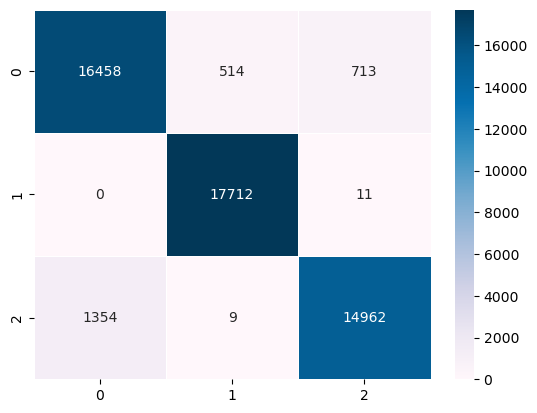

In [21]:
# No regularization
clf = LogisticRegression(max_iter=1000, solver='saga')

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)

In [22]:
# With L1 regularization
clf = LogisticRegression(max_iter=5000, solver='saga', penalty='l1')

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)

In [ ]:
# With L2 regularization
clf = LogisticRegression(max_iter=1000, solver='saga', penalty='l2')

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)

##### SVM

In [ ]:
clf = SVC()

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)

##### XGBoost

In [ ]:
clf = XGBClassifier(n_estimators=1000)

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)

##### Random Forest

In [ ]:
# using gini criteria
clf = RandomForestClassifier()

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)

##### Neural Network

In [ ]:
# using gini criteria
clf = MLPClassifier(hidden_layer_sizes=(4,4), max_iter=750)

y_pred = basic_train_and_test(clf, x_train, x_test, y_train, y_test)